In [2]:
! pip install seaborn

     |████████████████████████████████| 292 kB 2.5 MB/s eta 0:00:01


In [3]:
import requests
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import fiona
# import distancerasters as dr
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

## Preparing training data

In [4]:
lc = gpd.read_file('./Data/train.shp')
lc.head(5)

,cat,class,geometry
0,1,slum,"POLYGON ((-0.19924 5.58684, -0.19475 5.58440, ..."
1,1,slum,"POLYGON ((-0.19068 5.59266, -0.19291 5.59091, ..."
2,1,slum,"POLYGON ((-0.20432 5.58025, -0.20781 5.58216, ..."
3,1,slum,"POLYGON ((-0.21129 5.59688, -0.20952 5.59532, ..."
4,1,slum,"POLYGON ((-0.23741 5.55977, -0.23355 5.55797, ..."


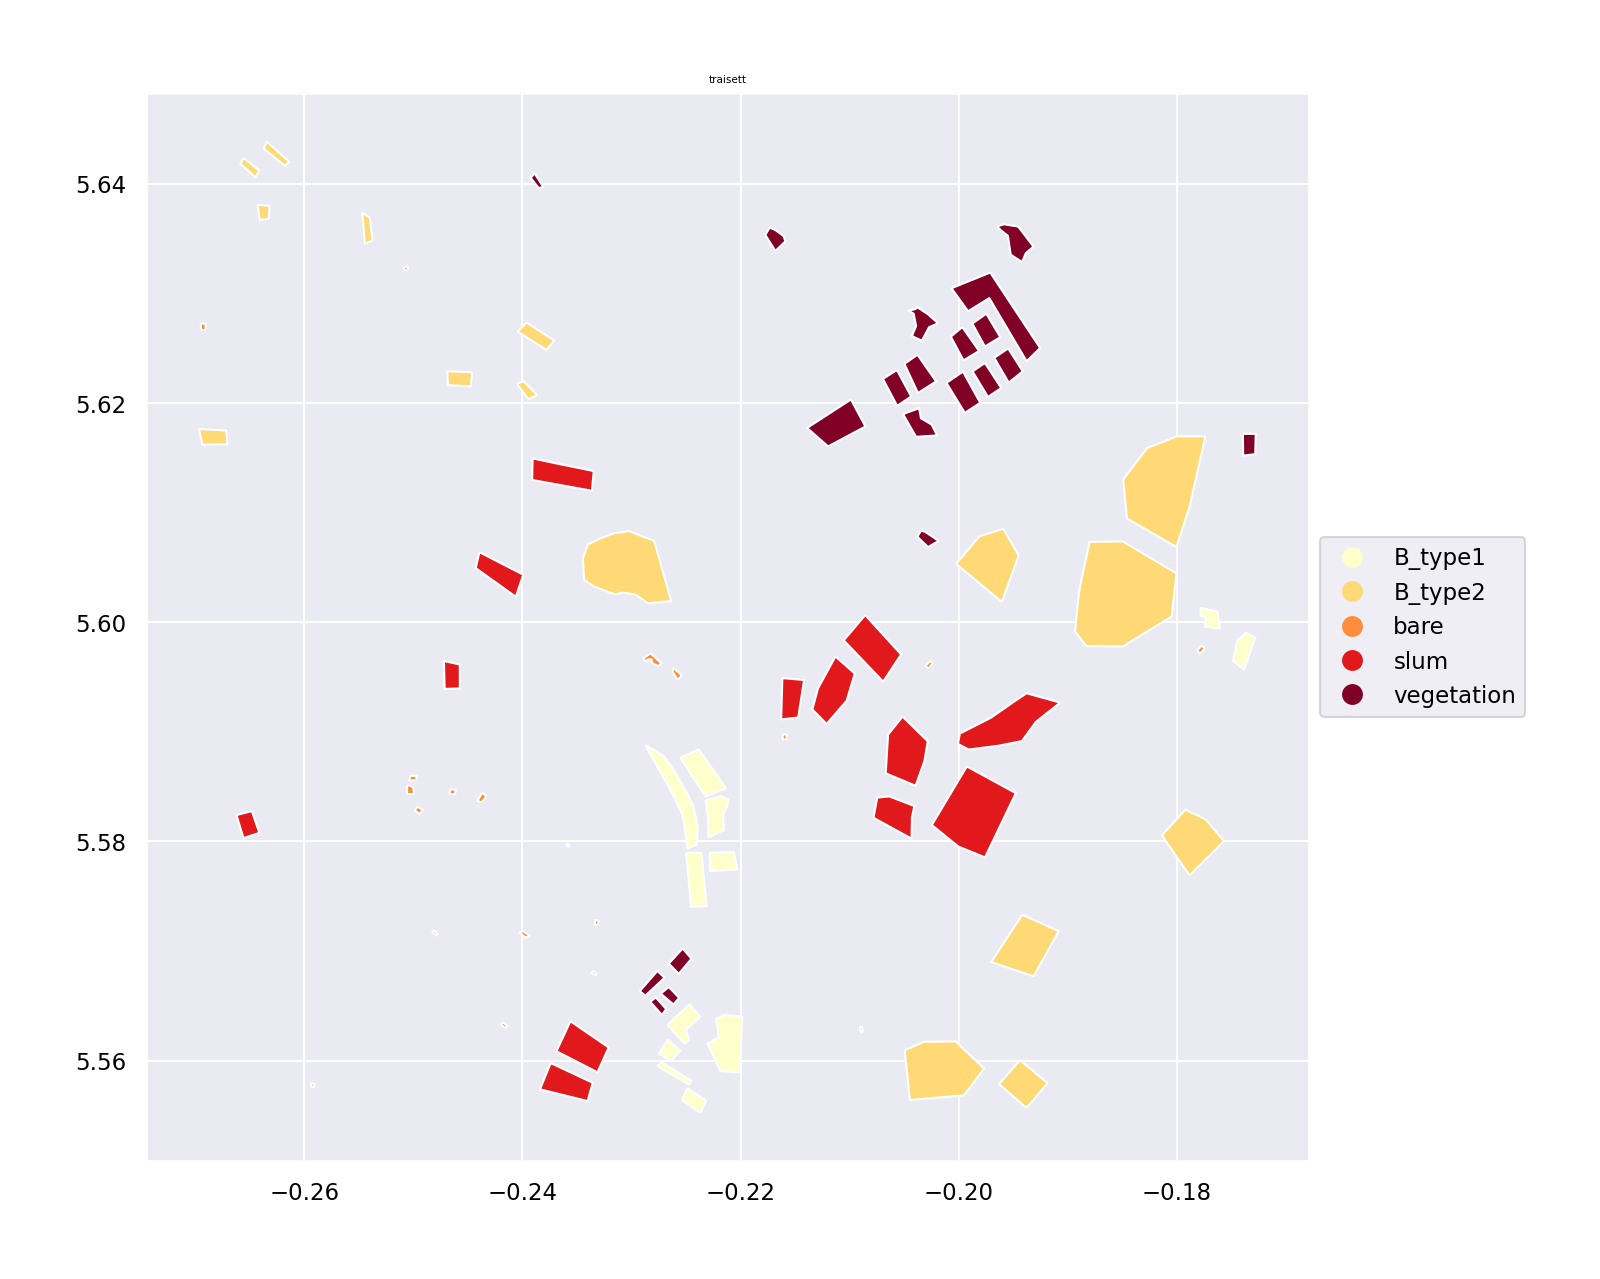

In [23]:
# Plot trainset 

fig, axes = plt.subplots(figsize=(10, 10), sharex=True)  
axes.set_title('traisett') 
lc.plot(ax=axes, column= 'class',  \
            cmap='YlOrRd', legend=True,
            legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)},
         )

plt.show()

In [6]:
lc.groupby(['cat'],as_index=False).agg('count')

,cat,class,geometry
0,1,13,13
1,2,20,20
2,3,12,12
3,4,16,16
4,5,20,20


In [9]:
from glob import glob

fp = sorted(glob('./Data/img/*.tiff'))
print(fp)


['./Data/img/B02.tiff',
 './Data/img/B03.tiff',
 './Data/img/B04.tiff',
 './Data/img/B08.tiff',
 './Data/img/NDVI.tiff']

In [10]:
import geowombat as gw
import os

outfile = './out/stack_acc1.tif'

with gw.config.update(ref_image=fp[0]):
    with gw.open(fp,stack_dim= 'band') as src:
        src.gw.to_raster(outfile, overwrite = True)

100%|███████████████████████████████████████████████████████████████████████████████████| 29/29 [00:07<00:00,  4.07it/s]


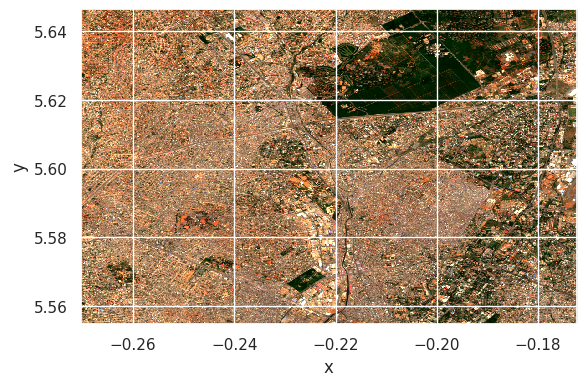

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=100)
with gw.open('./out/stack_acc.tif') as src:
    src.sel(band=[3,2,1]).plot.imshow(robust = True,ax=ax)
plt.tight_layout(pad = 1)

In [12]:
# Extract band values to shapefile
with gw.open(outfile) as src: 
    df = src.gw.extract(lc,  
                   band_names=src.band.values.tolist(),all_touched = True)
print(df.iloc[:,:])

       id  point                  geometry  cat    class       1       2  \
0       0      0  POINT (-0.26722 5.64639)    1     slum  0.0787  0.1162   
1       0      1  POINT (-0.26713 5.64639)    1     slum  0.0568  0.0934   
2       0      2  POINT (-0.26704 5.64639)    1     slum  0.0496  0.0845   
3       0      3  POINT (-0.26731 5.64630)    1     slum  0.0656  0.0920   
4       0      4  POINT (-0.26722 5.64630)    1     slum  0.0747  0.1153   
...    ..    ...                       ...  ...      ...     ...     ...   
77790  80  77790  POINT (-0.26821 5.64514)    4  B_type2  0.0914  0.1340   
77791  80  77791  POINT (-0.26812 5.64514)    4  B_type2  0.0919  0.1360   
77792  80  77792  POINT (-0.26803 5.64514)    4  B_type2  0.1026  0.1547   
77793  80  77793  POINT (-0.26794 5.64514)    4  B_type2  0.0992  0.1470   
77794  80  77794  POINT (-0.26785 5.64514)    4  B_type2  0.1062  0.1405   

            3       4     5     6     7  
0      0.1378  0.2999  0.31  0.54  0.18  
1  

In [13]:
# check for nan values
df.isnull().sum(axis = 0)

id          0
point       0
geometry    0
cat         0
class       0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
dtype: int64

 # Modeling 

In [25]:
from sklearn_xarray.preprocessing import Featurizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from geowombat.ml import fit, fit_predict
from sklearn.decomposition import PCA 
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
# Use a data pipeline
# pipe = Pipeline([
#             ('SimpleImputer', SimpleImputer(missing_values=np.nan, strategy="mean")),

#             ('Featurizer', Featurizer()),
#             ('scaler', StandardScaler()),
#             ('Kmean',KMeans(n_clusters=5, random_state=0))
#             ('rf', RandomForestClassifier(n_estimators=1000, max_depth=500, max_features='auto', min_samples_split=3))])

pipe = Pipeline([
            ('SimpleImputer', SimpleImputer(missing_values=np.nan, strategy="mean")),

            ('Featurizer', Featurizer()),
            ('scaler', StandardScaler()),
            ('Kmean',KMeans(n_clusters=5, random_state=0))])

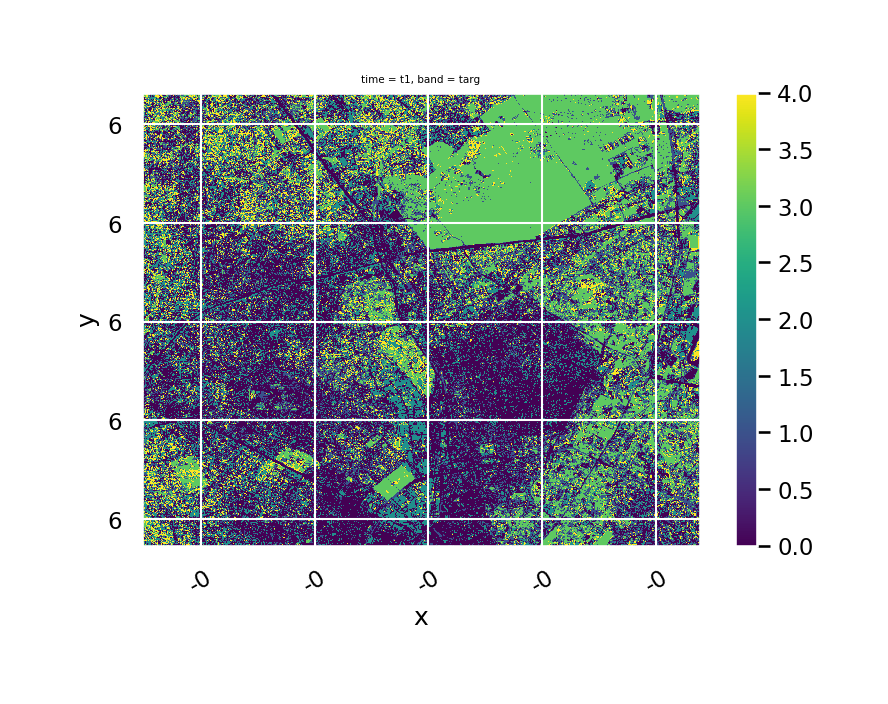

In [26]:
with gw.open(fp,stack_dim= 'band') as src:
    y = fit_predict(src, df, pipe, col='cat')
    y.sel(band='targ').gw.imshow()